<a href="https://colab.research.google.com/github/chenw410/MSSP_607/blob/main/Internet_Sales_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import statsmodels.api as se
import seaborn as sns
import datetime as dt
from sklearn.linear_model import LinearRegression
from scipy import stats
from io import StringIO
import itertools

%matplotlib inline
pd.set_eng_float_format(accuracy=3, use_eng_prefix=True)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [ ]:
internet_sales = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/MSSP-607/Assignments/assignment 2/Internet Sales.csv', parse_dates=['BirthDate','DateFirstPurchase','OrderDate','DueDate','ShipDate'],
                   low_memory=False) #index_col='ID'#
internet_sales

,Unnamed: 0,CustomerKey,GeographyKey,City,CountryRegionCode,EnglishCountryRegionName,CustomerAlternateKey,Title,FirstName,MiddleName,...,ProductStandardCost,TotalProductCost,SalesAmount,TaxAmt,Freight,CarrierTrackingNumber,CustomerPONumber,OrderDate,DueDate,ShipDate
0,0,11000,26,Rockhampton,AU,Australia,AW00011000,NaN,Jon,V,...,1912.15,1912.15,3399.99,272.00,85.00,NaN,NaN,2011-01-19,2011-01-31,2011-01-26
1,1,11000,26,Rockhampton,AU,Australia,AW00011000,NaN,Jon,V,...,1265.62,1265.62,2319.99,185.60,58.00,NaN,NaN,2013-01-18,2013-01-30,2013-01-25
2,2,11000,26,Rockhampton,AU,Australia,AW00011000,NaN,Jon,V,...,8.22,8.22,21.98,1.76,0.55,NaN,NaN,2013-01-18,2013-01-30,2013-01-25
3,3,11000,26,Rockhampton,AU,Australia,AW00011000,NaN,Jon,V,...,1481.94,1481.94,2384.07,190.73,59.60,NaN,NaN,2013-05-03,2013-05-15,2013-05-10
4,4,11000,26,Rockhampton,AU,Australia,AW00011000,NaN,Jon,V,...,10.84,10.84,28.99,2.32,0.72,NaN,NaN,2013-05-03,2013-05-15,2013-05-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60393,60393,29480,248,London,GB,United Kingdom,AW00029480,NaN,Nina,W,...,13.09,13.09,34.99,2.80,0.87,NaN,NaN,2013-07-17,2013-07-29,2013-07-24
60394,60394,29480,248,London,GB,United Kingdom,AW00029480,NaN,Nina,W,...,6.92,6.92,8.99,0.72,0.22,NaN,NaN,2013-07-17,2013-07-29,2013-07-24
60395,60395,29481,120,Hof,DE,Germany,AW00029481,NaN,Ivan,NaN,...,1898.09,1898.09,3374.99,270.00,84.37,NaN,NaN,2011-08-13,2011-08-25,2011-08-20
60396,60396,29482,179,Saint Ouen,FR,France,AW00029482,NaN,Clayton,NaN,...,1105.81,1105.81,2049.10,163.93,51.23,NaN,NaN,2012-09-18,2012-09-30,2012-09-25


In [ ]:
#Return a dataframe for the graph by day of the order
internet_sales.groupby(internet_sales['OrderDate'].dt.year,as_index=True).agg({'SalesAmount':'sum'})


,SalesAmount
OrderDate,
2010,43421.04
2011,7075525.93
2012,5842485.20
2013,16351550.34
2014,45694.72


In [ ]:
internet_sales = internet_sales.assign(orderyear = internet_sales['OrderDate'].dt.year)
internet_sales = internet_sales.assign(orderquarter = internet_sales['OrderDate'].dt.quarter)
internet_sales = internet_sales.assign(ordermonth = internet_sales['OrderDate'].dt.month)
internet_sales = internet_sales.assign(orderday = internet_sales['OrderDate'].dt.day)
internet_sales = internet_sales.assign(daynumber = internet_sales['orderyear']+internet_sales['ordermonth']+internet_sales['orderday'])

internet_sales.groupby(['orderyear','orderquarter']).agg({'SalesAmount':'sum'},as_index=True )

SalesAmount
orderyear orderquarter             
2010      4                43421.04
2011      1              1421357.48
          2              1801595.14
          3              1814387.99
          4              2038185.32
2012      1              1375841.32
          2              1314373.65
          3              1454653.06
          4              1697617.17
2013      1              2678946.04
          2              3973793.48
          3              4370237.06
          4              5328573.76
2014      1                45694.72

In [ ]:
internet_sales.shape

(60398, 65)

In [ ]:
#Drop outliers in 2010 and 2014 to have valid sales: December 2010 and January 2014 were short months.
internet_sales.query('"2010-12-31" < OrderDate' , inplace=True)
internet_sales.query('OrderDate < "2013-12-29"', inplace=True)
internet_sales.groupby(['orderyear','orderquarter']).agg({'SalesAmount':'sum'},as_index=True )

SalesAmount
orderyear orderquarter             
2011      1              1421357.48
          2              1801595.14
          3              1814387.99
          4              2038185.32
2012      1              1375841.32
          2              1314373.65
          3              1454653.06
          4              1697617.17
2013      1              2678946.04
          2              3973793.48
          3              4370237.06
          4              5323427.85

In [ ]:
internet_sales.shape

(58175, 65)

In [ ]:
yearly_sales = internet_sales.groupby(['orderyear'], as_index=False).agg({'SalesAmount':'sum'}) 
yearly_sales

,orderyear,SalesAmount
0,2011,7075525.93
1,2012,5842485.20
2,2013,16346404.43


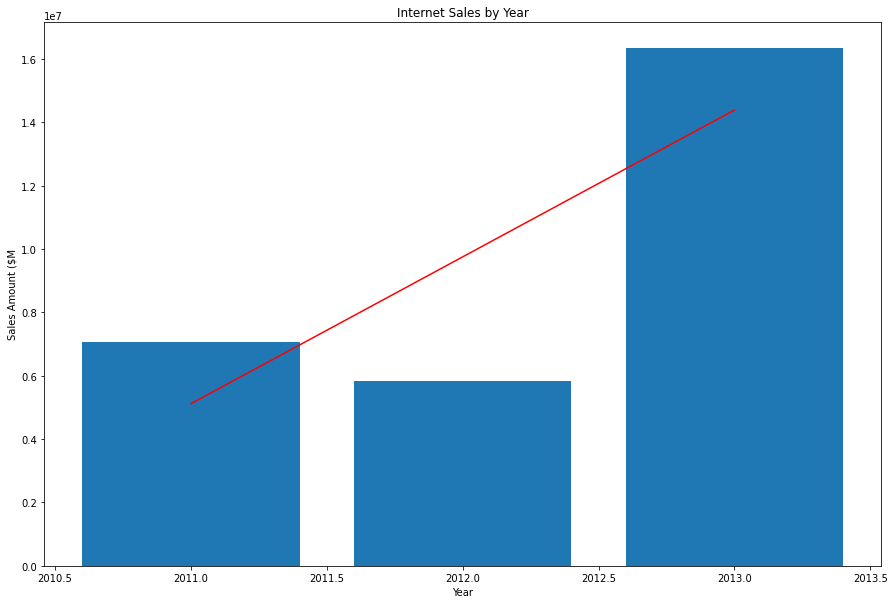

In [ ]:
fig = plt.figure(figsize = (15, 10))
ax1 = plt.bar(yearly_sales['orderyear'], yearly_sales['SalesAmount'])

z = np.polyfit(yearly_sales['orderyear'], yearly_sales['SalesAmount'], deg=1)
p = np.poly1d(z)
plt.plot(yearly_sales['orderyear'], p(yearly_sales['orderyear']), color='red')

plt.xlabel("Year")
plt.ylabel("Sales Amount ($M")
plt.title("Internet Sales by Year")

plt.show()

In [ ]:
yearly_sales = internet_sales.groupby(['OrderDate','daynumber'], as_index=False).agg({'SalesAmount':'sum'}) 
#yearly_sales.sort_values(by=["OrderDate])
yearly_sales

,OrderDate,daynumber,SalesAmount
0,2011-01-01,2013,7156.54
1,2011-01-02,2014,15012.18
2,2011-01-03,2015,14313.08
3,2011-01-04,2016,7855.64
4,2011-01-05,2017,7855.64
...,...,...,...
1085,2013-12-24,2049,69533.64
1086,2013-12-25,2050,58080.78
1087,2013-12-26,2051,78906.59
1088,2013-12-27,2052,60959.78


<Figure size 1080x360 with 0 Axes>

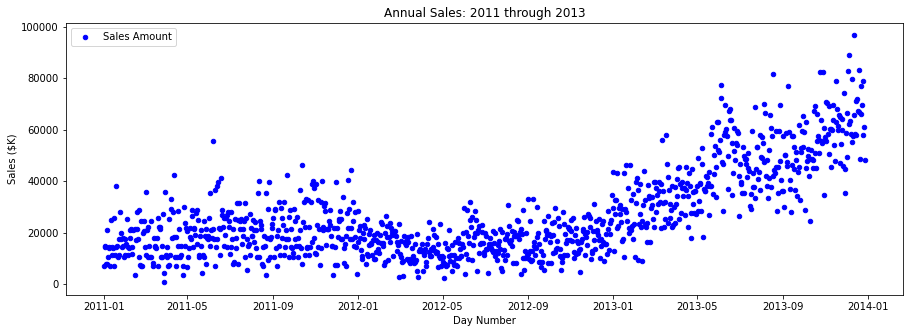

In [ ]:
fig = plt.figure()
fig.autofmt_xdate(ha='center')
fig.set_size_inches(15,5)
ax1 = fig.add_subplot
ax1 = yearly_sales.plot.scatter(x='OrderDate',y='SalesAmount',label='Sales Amount', color='blue', figsize=(15,5))
ax1.set_ylabel('Sales ($K)')
ax1.set_xlabel('Day Number')
ax1.set_title('Annual Sales: 2011 through 2013')
ax1.legend()
ax1.set_yscale('linear')


In [ ]:
plt.close('all')

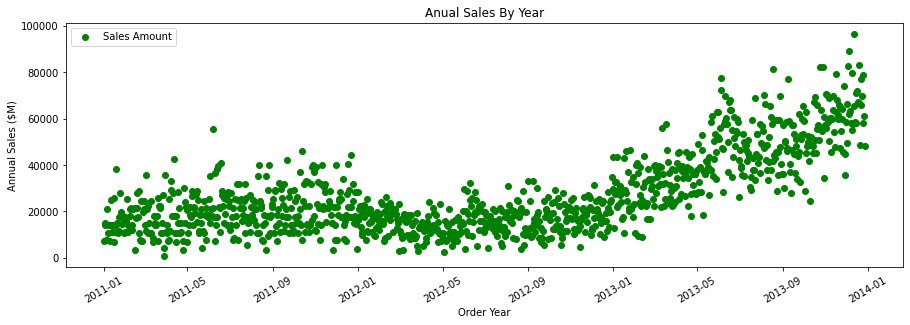

In [ ]:
fig, ax1 = plt.subplots()
fig.autofmt_xdate(ha='center')
fig.set_size_inches(15,5)

ax1.scatter(x='OrderDate',y='SalesAmount', data=yearly_sales, label='Sales Amount', color ='green')
ax1.set_ylabel('Annual Sales ($M)')
ax1.set_xlabel('Order Year')
ax1.set_title('Anual Sales By Year')
ax1.legend()


In [ ]:
plt.close('all')


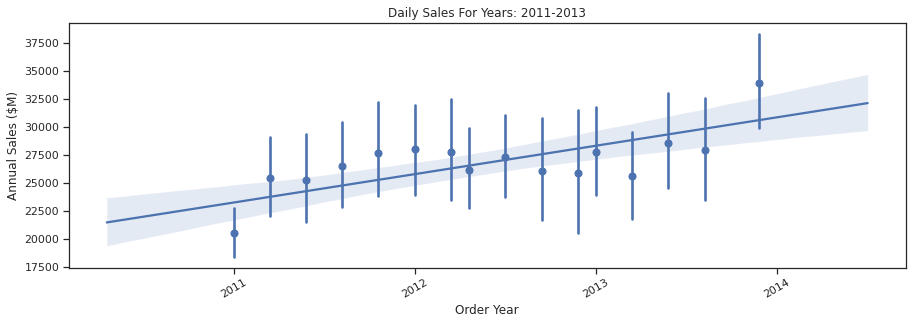

In [ ]:
sns.set(rc={"figure.figsize":(15, 5)}) #width=15, height=5
sns.set_theme(style="ticks")

fig, ax1 = plt.subplots(figsize=(15, 5))
fig.autofmt_xdate(ha='center')

ax1 = sns.regplot(data=yearly_sales, x='daynumber', y="SalesAmount", scatter=True, x_bins=16, x_estimator=np.mean, x_ci= "ci", ci=95)
_ = ax1.set(
    title="Daily Sales For Years: 2011-2013",
    xticklabels=["2010", "2011", "2012", "2013", "2014"],
    xlabel="Order Year",
    ylabel='Annual Sales ($M)'
)

In [ ]:
import statsmodels.formula.api as sm
x = np.array(yearly_sales['daynumber'])
y = np.array(yearly_sales['SalesAmount'])
result = sm.ols('SalesAmount~daynumber',yearly_sales).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:            SalesAmount   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     22.16
Date:                Tue, 25 Oct 2022   Prob (F-statistic):           2.83e-06
Time:                        19:24:22   Log-Likelihood:                -12156.
No. Observations:                1090   AIC:                         2.432e+04
Df Residuals:                    1088   BIC:                         2.433e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.902e+05    1.1e+05     -4.463      0.0

In [ ]:
print(result.params)

Intercept   -490168.22
daynumber       254.16
dtype: float64


In [ ]:
import statsmodels.api as sm
nsample = 1090
x = np.linspace(0, 20, nsample)
X = np.column_stack((x, (x - 5) ** 2))
X = sm.add_constant(X)
beta = [5.0, 0.5, -0.01]
sig = 0.5
w = np.ones(nsample)
w[nsample * 6 // 10 :] = 3
y_true = np.dot(X, beta)
e = np.random.normal(size=nsample)
y = y_true + sig * w * e
X = X[:, [0, 1]]

In [ ]:
x = np.array(yearly_sales['daynumber'])
y = np.array(yearly_sales['SalesAmount'])
mod_wls = sm.WLS(y, X, weights=1.0 / (w ** 2))
res_wls = mod_wls.fit()
print(res_wls.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.088
Model:                            WLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     104.4
Date:                Tue, 25 Oct 2022   Prob (F-statistic):           1.79e-23
Time:                        22:31:15   Log-Likelihood:                -11855.
No. Observations:                1090   AIC:                         2.371e+04
Df Residuals:                    1088   BIC:                         2.372e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.42e+04    581.527     24.415      0.0

In [ ]:
X = yearly_sales[['daynumber']]
y = yearly_sales['SalesAmount']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #0.2 for test, 0.8 for train

from sklearn  import linear_model 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt

# Train the model
model = linear_model.LinearRegression()
model.fit(X, y)
y_hat = model.predict(X_test)

# Model performance
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Coefficient of determination (R^2): %.3f' % r2_score(y_test, y_hat))
print('Mean squared error (MSE): %.3f'% mean_squared_error(y_test, y_hat))
print('Root mean squared error (RMSE) : %.3f'% sqrt(mean_squared_error(y_test, y_hat)) )

Coefficients: [254.16072079]
Intercept: -490168.21549706935
Coefficient of determination (R^2): 0.041
Mean squared error (MSE): 309159888.039
Root mean squared error (RMSE) : 17582.943


In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(random_state=42)  #split into random sets
forest_reg.fit(X_train, y_train)
print('Random Forest R squared: %.3f' % forest_reg.score(X_test, y_test))

y_hat = forest_reg.predict(X_test)
forest_mse = mean_squared_error(y_test, y_hat)
forest_rmse = np.sqrt(forest_mse)
print('Random Forest RMSE: %.3f' % forest_rmse)

Random Forest R squared: -0.021
Random Forest RMSE: 18147.650


In [ ]:
y_hat

array([29758.94553058, 25104.12332424, 25698.57706789, 28956.61110026,
       25104.12332424, 22563.41666046, 25698.57706789, 28685.5265926 ,
       28069.71599835, 27370.65587339, 28320.62487765, 28163.15403951,
       23214.50308127, 27857.54417446, 20513.19637665, 26262.86568602,
       28069.71599835, 24718.05527189, 22049.49020141, 25767.68947486,
       25104.12332424, 28163.15403951, 28010.99888253, 28840.47171   ,
       26262.86568602, 28840.47171   , 20513.19637665, 27108.15173696,
       28010.99888253, 25767.68947486, 28163.15403951, 27370.65587339,
       22049.49020141, 27223.72835667, 26262.86568602, 28188.72767798,
       28188.72767798, 32350.78683146, 29958.79467209, 28306.15658089,
       28188.72767798, 28840.47171   , 28306.15658089, 25104.12332424,
       26662.96923584, 24718.05527189, 28306.15658089, 25698.57706789,
       28471.74898931, 28598.12702239, 27857.54417446, 28163.15403951,
       27108.15173696, 27857.54417446, 23214.50308127, 22563.41666046,
      

In [ ]:
y_hat = pd.DataFrame(y_hat)
y_hat

,0
0,29758.95
1,25104.12
2,25698.58
3,28956.61
4,25104.12
...,...
213,28384.18
214,27108.15
215,24718.06
216,25698.58


Random Forest RMSE: 15392.306


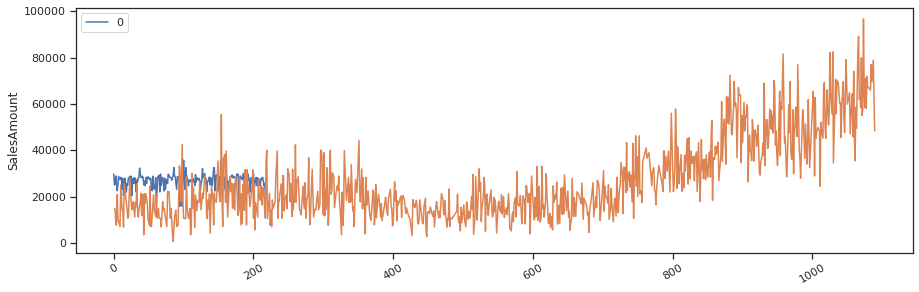

In [ ]:
sns.set(rc={"figure.figsize":(15, 5)}) #width=15, height=5
sns.set_theme(style="ticks")

fig, ax1 = plt.subplots(figsize=(15, 5))
fig.autofmt_xdate(ha='center')

sns.lineplot(data=y_hat)
sns.lineplot(data=y_train)
y_hat = forest_reg.predict(X_test)
forest_mse = mean_squared_error(y_test, y_hat)
forest_rmse = np.sqrt(forest_mse)
print('Random Forest RMSE: %.3f' % forest_rmse) #whether the prediction close to the forecast

In [ ]:
plt.close('all')

In [ ]:
yearly_sales = internet_sales.groupby(['OrderDate'], as_index=True).agg({'SalesAmount':'sum'}) 
yearly_sales

,SalesAmount
OrderDate,
2011-01-01,7156.54
2011-01-02,15012.18
2011-01-03,14313.08
2011-01-04,7855.64
2011-01-05,7855.64
...,...
2013-12-24,69533.64
2013-12-25,58080.78
2013-12-26,78906.59


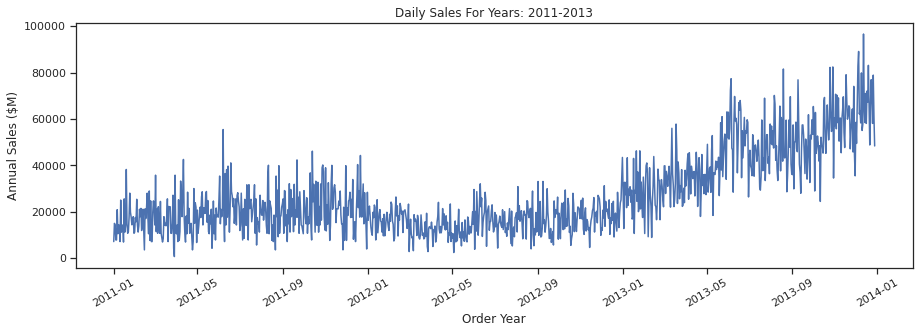

In [ ]:
sns.set(rc={"figure.figsize":(15, 5)}) #width=15, height=5
sns.set_theme(style="ticks")

fig, ax1 = plt.subplots(figsize=(15, 5))
fig.autofmt_xdate(ha='center')
_ = ax1.set(
    title="Daily Sales For Years: 2011-2013",
    #xticklabels=["2010", "2011", "2012", "2013", "2014"],
    xlabel="Order Year",
    ylabel='Annual Sales ($M)'
)
plt.plot(yearly_sales.index,yearly_sales['SalesAmount'])

In [ ]:
train = yearly_sales[yearly_sales.index < pd.to_datetime("2013-01-01", format='%Y-%m-%d')] #old data as the index
test = yearly_sales[yearly_sales.index > pd.to_datetime("2013-01-01", format='%Y-%m-%d')]
train

,SalesAmount
OrderDate,
2011-01-01,7156.54
2011-01-02,15012.18
2011-01-03,14313.08
2011-01-04,7855.64
2011-01-05,7855.64
...,...
2012-12-27,19556.77
2012-12-28,23892.13
2012-12-29,25080.36


Text(0.5, 0, 'Train/Test Split for Yearly Sales Data')

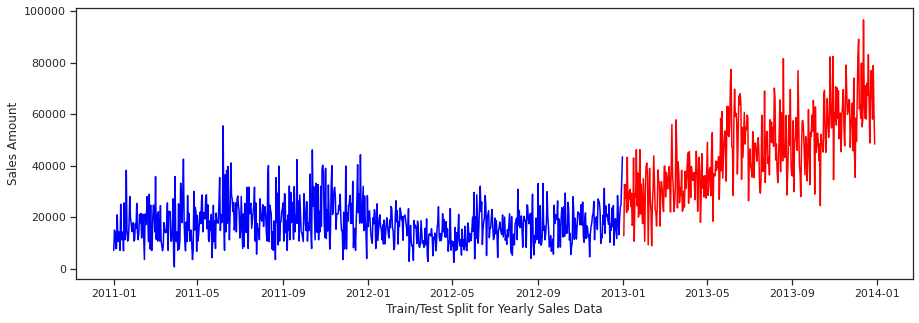

In [ ]:
plt.plot('SalesAmount', data=train, color = 'blue')
plt.plot('SalesAmount', data=test, color = 'red')
plt.ylabel('Sales Amount')
plt.xlabel('Train/Test Split for Yearly Sales Data')

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX #average moving regression
endog = train
endog
mod_ar2 = SARIMAX(endog, order=(2,0,0))
res_ar2 = mod_ar2.fit()
print(res_ar2.summary())

                               SARIMAX Results                                
Dep. Variable:            SalesAmount   No. Observations:                  728
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -7651.340
Date:                Tue, 25 Oct 2022   AIC                          15308.679
Time:                        19:24:24   BIC                          15322.450
Sample:                             0   HQIC                         15313.993
                                - 728                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4241      0.031     13.781      0.000       0.364       0.484
ar.L2          0.5037      0.030     16.960      0.000       0.445       0.562
sigma2       7.87e+07   4.28e-11   1.84e+18      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
mod = se.tsa.statespace.SARIMAX(y,
                                order=(0, 0, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
#print(results.summary().tables[1])
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        SalesAmount   No. Observations:                 1090
Model:             SARIMAX(0, 0, 1)x(1, 1, 1, 12)   Log Likelihood              -11352.340
Date:                            Tue, 25 Oct 2022   AIC                          22712.680
Time:                                    19:24:25   BIC                          22732.559
Sample:                                         0   HQIC                         22720.213
                                           - 1090                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1201      0.041      2.911      0.004       0.039       0.201
ar.S.L12      -0.0324      0.063   

**Seasonal Forecast 5 Steps ahead using moving average.**

https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html?highlight=sarimax#statsmodels.tsa.statespace.sarimax.SARIMAX

In [ ]:
y = yearly_sales
y.head(5)
#y.index

,SalesAmount
OrderDate,
2011-01-01,7156.54
2011-01-02,15012.18
2011-01-03,14313.08
2011-01-04,7855.64
2011-01-05,7855.64


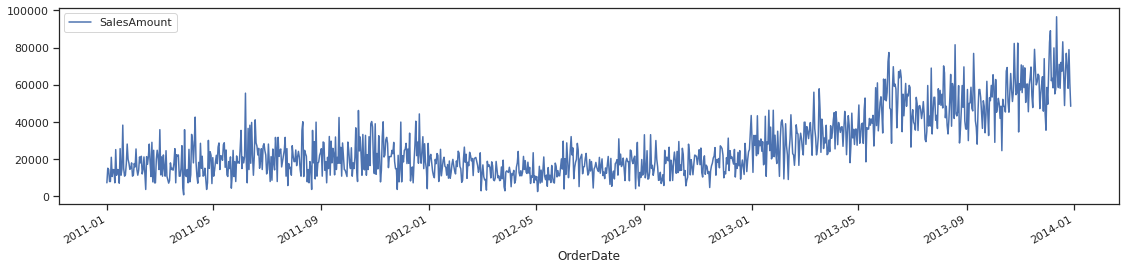

In [ ]:
yearly_sales.plot(figsize=(19, 4))
plt.show()

In [ ]:
#The models notation is SARIMA(p, d, q).(P,D,Q)m. These three parameters account #does my data have seasonality
#for seasonality, trend, and noise in data
#p = d = q = range(0, 2)
#pdq = list(itertools.product(p, d, q))
#seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
#print('Examples of parameter for SARIMA...')
#print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
#print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
#print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
#print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
#for param in pdq:
#   for param_seasonal in seasonal_pdq:
#        try:
#           mod = sm.tsa.statespace.SARIMAX(y,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
#          results = mod.fit()
#         print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
#    except: 
#       continue

In [ ]:
#Given a collection of models for the data, AIC estimates the quality of each model, 
#relative to each of the other models. The low AIC value the better. Our output suggests 
#that SARIMAX(0, 0, 1)x(1, 1, 1, 12) with AIC value of 22713 is the best combination, 
#so we should consider this to be optimal option.
mod = SARIMAX(y, order=(0, 0, 1),
              seasonal_order=(1, 1, 1, 12),
              enforce_stationarity=False,
              enforce_invertibility=False)
results = mod.fit()
print(results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                                     SARIMAX Results                                      
Dep. Variable:                        SalesAmount   No. Observations:                 1090
Model:             SARIMAX(0, 0, 1)x(1, 1, 1, 12)   Log Likelihood              -11352.340
Date:                            Tue, 25 Oct 2022   AIC                          22712.680
Time:                                    19:24:26   BIC                          22732.559
Sample:                                         0   HQIC                         22720.213
                                           - 1090                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1201      0.041      2.911      0.004       0.039       0.201
ar.S.L12      -0.0324      0.063   

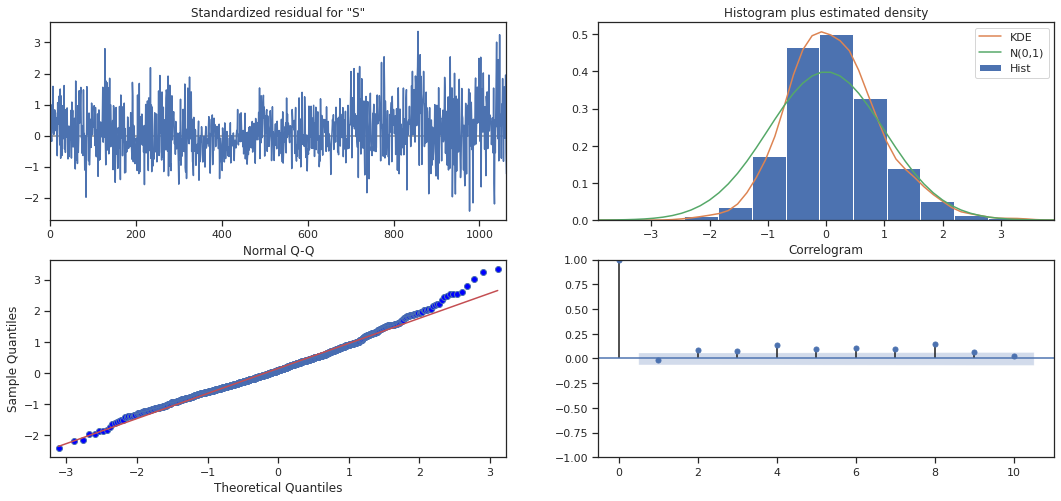

In [ ]:
#With the diagnostic below we can visualize important information 
#as the distribution and the Auto correlation function ACF (correlogram). 
#Values upward the “0” has some correlation over the time series data. 
#Values near to “1” demonstrates strongest correlation.

results.plot_diagnostics(figsize=(18, 8))
plt.show()

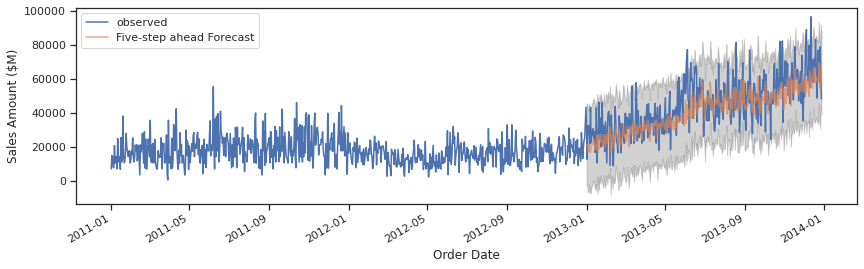

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2013-01-01'), steps=5, dynamic=False) #good but not 95% great
pred_ci = pred.conf_int()
ax = y['SalesAmount'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Five-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Order Date')
ax.set_ylabel('Sales Amount ($M)')
plt.legend()
plt.show()